In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
# Set random seed
rnd = np.random
rnd.seed(2)

In [3]:
# Number of clients
n = 15
# x- and y-coordinates of clients
xc = rnd.random(n+1)*200
yc = rnd.random(n+1)*200

In [4]:
# Problem setup
# Set of clients
N = [i for i in range(1, n+1)]
# Set of vertices
depot = 0
V = [depot] + N
# Set of arcs, {(i,j) in V^2 : i != j}
A = [(i,j) for i in V for j in V if i != j]

# Distance metric, euclidean
def distance(i,j):
    return float(np.hypot(xc[i] - xc[j], yc[i] - yc[j]))

# Cost of travelling between nodes
c = {(i,j): distance(i,j) for i,j in A}
# Capacity of agents
Q = 8
# Demand per client
q = {i: rnd.randint(1,4) for i in N}

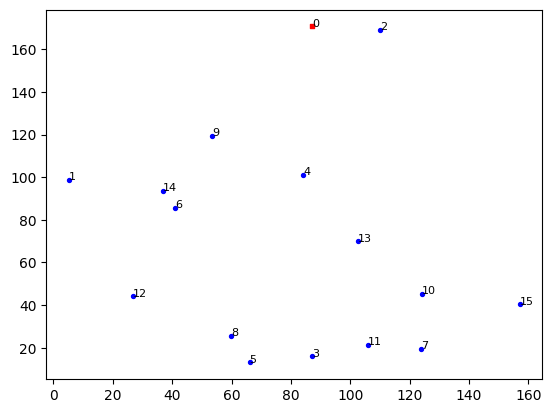

In [5]:
# Visualization of map
size = 8
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
plt.scatter(xc[N], yc[N], c='b', s=size)
for i in V:
    plt.text(xc[i], yc[i], str(i), fontsize=8)

In [6]:
# --- Simulated annealing, functions
def initial_solution():
    routes = []
    remaining_nodes = set(N)
    while remaining_nodes:
        route = []
        capacity = 0

        for i in sorted(remaining_nodes, key=lambda x: -q[x]): # Sort by descending demand
            if capacity + q[i] <= Q:
                route.append(i)
                capacity += q[i]
        for i in route:
            remaining_nodes.remove(i)
        routes.append(route)
    return routes

# Calculate the total cost of a solution
def total_cost(routes):

    base_cost = 0
    penalty_cost = 0
    penalty_rate = 10 # Penalty per unit of demand over the vehicle capacity

    for route in routes:
        # Calculate cost of route
        route_cost = distance(depot, route[0]) # Start at depot
        for i in range(len(route) - 1):
            route_cost += distance(route[i], route[i+1])
        route_cost += distance(route[-1], depot) # Return to depot
        base_cost += route_cost

        # Calculate penalty cost for exceeding capacity
        route_demand = sum(q[i] for i in route)
        if route_demand > Q:
            penalty_cost += penalty_rate * (route_demand - Q)

    cost = base_cost + penalty_cost
    return cost

# Check if a solution is feasible
def is_feasible(routes, max_vehicles):
    """
    Check if a solution is feasible:
    A) Each route's total demand must not exceed the vehicle capacity
    B) The number of routes must not exceed the maximum allowed vehicles
    """
    # A) Allowed, but penalized
    """
    for route in routes:
        if sum(q[i] for i in route) > Q:
            return False
    """
    # B)
    if len(routes) > max_vehicles:
        return False
    
    return True

# Perform a random move
def random_move(routes, max_vehicles):

    new_routes = [list(route) for route in routes]
    # Choose a random route and modify it
    if random.random() < 0.5:
        # Swap two customers within a route
        route = random.choice(new_routes)
        if len(route) > 1:
            i, j = random.sample(range(len(route)), 2)
            route[i], route[j] = route[j], route[i]
        
    else:
        # Move a customer from one route to another
        if len(new_routes) > 1:
            start_route = random.choice(new_routes)
            target_route = random.choice(new_routes)

            if start_route and sum(q[i] for i in target_route) < Q: # TODO: Check cost constraint for this one, not required perhaps?
                customer = start_route.pop(random.randrange(len(start_route)))
                if sum(q[i] for i in target_route) + q[customer] <= Q: # TODO: Check cost constraint for this one, not required perhaps?
                    target_route.append(customer)
                else:
                    start_route.append(customer) # Reverse move if infeasible
            
    # Remove empty routes
    new_routes = [route for route in new_routes if route]

    # Ensure the number of routes does not exceed the maximum allowed
    while len(new_routes) > max_vehicles:
        # Find pair of routes with the lowest combined cost
        best_merge = None
        best_merge_cost = float('inf')
        for i, route1 in enumerate(new_routes):
            for j, route2 in enumerate(new_routes):

                if i >= j: # Avoid duplicate pairs and self-pairs
                    continue
                # Compute the combined cost of merging route1 and route2
                merged_route = route1+ route2
                merged_cost = sum(c[merged_route[k], merged_route[k+1]] for k in range(len(merged_route)-1)) # TODO: Maybe create a function to calculate cost of route, embed into total_cost aswell
                if merged_cost < best_merge_cost:
                    best_merge = (i,j)
                    best_merge_cost = merged_cost

        # Merge the two routes with the lowest combined cost
        if best_merge:
            i, j = best_merge
            new_routes[i] += new_routes[j]
            del new_routes[j] # Remove the second route
    
    return new_routes


In [7]:
solution_example = initial_solution()
print(solution_example)

[[1, 6, 2], [8, 13, 3], [15, 5, 9, 4], [10, 11, 12, 7, 14]]


In [8]:
# --- Simulated annealing algorithm
def simulated_annealing():
    # Parameters
    T = 1000 # Initial temperature
    alpha = 0.99 # Cooling rate
    min_T = 0.1 # Minimum temperature
    max_iterations = 1000 # Maximum iterations at each temperature
    max_vehicles = 5

    # Initial solution
    current_solution = initial_solution()
    current_cost = total_cost(current_solution)
    best_solution = current_solution
    best_cost = current_cost

    # Data for plotting
    temperatures = []
    current_costs = []
    best_costs = []

    iteration = 0 # Keep track of iterations
    while T > min_T:
        for _ in range(max_iterations):
            iteration += 1
            # Generate a neighbour solution
            neighbour = random_move(current_solution, max_vehicles)
            if not is_feasible(neighbour, max_vehicles):
                continue

            neighbour_cost = total_cost(neighbour)
            # Acceptance probability
            if neighbour_cost < current_cost or random.random() < math.exp((current_cost-neighbour_cost) / T):
                current_solution = neighbour
                current_cost = neighbour_cost
                # Update the best solution
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost
                    print('Iteration {}: New best solution found.'.format(iteration))
                    print('Routes: {}'.format(best_solution))
                    print('Cost: {}'.format(best_cost))
                    print('---')
                
            # Track data for plots
            temperatures.append(T)
            current_costs.append(current_cost)
            best_costs.append(best_cost)
        
        # Debug print at each temperature step
        print('Temperature: {}, Current cost: {}, Best Cost: {}'.format(round(T, 3), round(current_cost, 2), round(best_cost, 2)))

        # Cool down
        T *= alpha

    # Final best solution
    print('--- Final best folution:')
    print('Routes: {}'.format(best_solution))
    print('Cost: {}'.format(best_cost))

    return best_solution, best_cost, temperatures, current_costs, best_costs


In [9]:
# Run the algorithm
best_routes, best_cost, temperatures, current_costs, best_costs = simulated_annealing()

Iteration 1: New best solution found.
Routes: [[1, 6, 2], [8, 3, 13], [15, 5, 9, 4], [10, 11, 12, 7, 14]]
Cost: 1618.690693338287
---
Iteration 2: New best solution found.
Routes: [[1, 6, 2], [8, 3, 13], [15, 5, 9, 4], [12, 11, 10, 7, 14]]
Cost: 1553.9438299613557
---
Iteration 24: New best solution found.
Routes: [[2, 1, 6], [8, 3, 13], [9, 5, 15, 4], [12, 14, 10, 11, 7]]
Cost: 1542.1245277274652
---
Iteration 28: New best solution found.
Routes: [[2, 1, 6], [8, 3, 13], [9, 5, 15, 4], [12, 14, 10, 7, 11]]
Cost: 1532.6331548113785
---
Iteration 123: New best solution found.
Routes: [[6, 1, 2], [13, 8, 3], [9, 4, 15, 5], [11, 7, 10, 12, 14]]
Cost: 1512.4534084877484
---
Iteration 125: New best solution found.
Routes: [[1, 6, 2], [13, 8, 3], [9, 4, 15, 5], [11, 7, 10, 12, 14]]
Cost: 1506.8496092745042
---
Iteration 142: New best solution found.
Routes: [[2, 1, 6], [13, 8, 3], [9, 4, 15, 5], [10, 7, 11, 12, 14]]
Cost: 1477.6151167091057
---
Iteration 149: New best solution found.
Routes: 

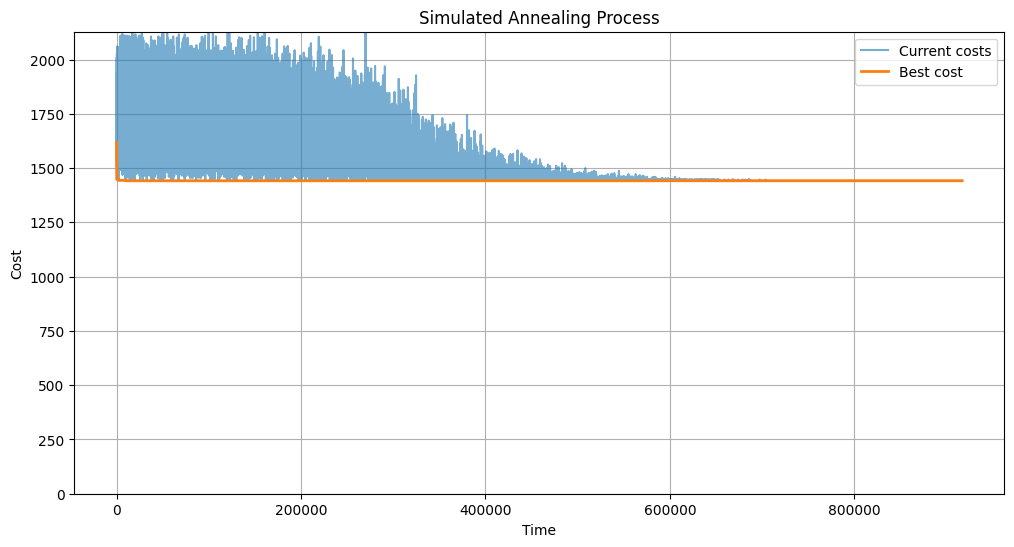

In [11]:
# Plot results
plt.figure(figsize=(12,6))
x = range(len(temperatures))
plt.plot(x, current_costs, label='Current costs', alpha=0.6)
plt.plot(x, best_costs, label='Best cost', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Cost')
plt.ylim(0, max(current_costs))
plt.title('Simulated Annealing Process')
plt.legend()
plt.grid()
plt.show()

In [12]:
paths = []
for route in best_routes:
    path = []
    for i, node in enumerate(route):
        if i == 0:
            path.append((depot,node))
        else:
            path.append((route[i-1], node))
    path.append((route[-1], depot))
    paths.append(path)

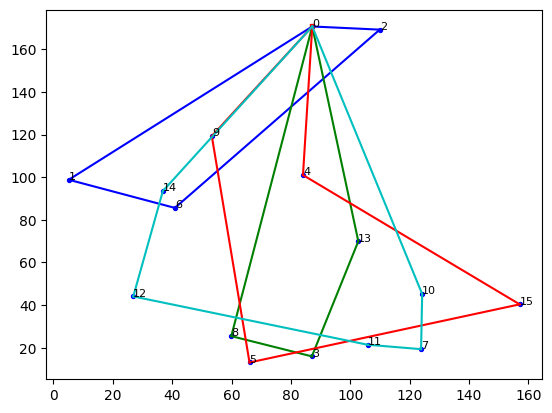

In [13]:
# Visualization of results
size = 8
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
plt.scatter(xc[N], yc[N], c='b', s=size)
for i in V:
    plt.text(xc[i], yc[i], str(i), fontsize=8)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for k, path in enumerate(paths):
    for i,j in path:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=colors[k%len(colors)])